# BGS Signal-to-Noise Ratio and Redshift Efficiency

The goal of this notebook is to assess the signal-to-noise ratio and redshift efficiency of BGS targets observed in "nominal" observing conditions (which are defined [here](https://github.com/desihub/desisurvey/blob/master/py/desisurvey/data/config.yaml#L102) and discussed [here](https://github.com/desihub/desisurvey/issues/77), among other places).  Specifically, the nominal BGS observing conditions we adopt (note the 5-minute exposure time is with the moon down!) are:

```python
{'AIRMASS': 1.0,
 'EXPTIME': 300,
 'SEEING': 1.1,
 'MOONALT': -60,
 'MOONFRAC': 0.0,
 'MOONSEP': 180}
```

During the survey itself, observations with the moon up (i.e., during bright time) will be obtained with longer exposure times according to the bright-time exposure-time model (see [here](https://github.com/desihub/surveysim/tree/master/doc/nb)).

Because we fix the observing conditions, we only consider how redshift efficiency depends on galaxy properties (apparent magnitude, redshift, 4000-A break, etc.).  However, note that the code is structured such that we *could* (now or in the future) explore variations in seeing, exposure time, and lunar parameters.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` and `desitarget.mock.build.targets_truth`.

Finally, note that the various python Classes instantiated here (documented in `desitarget.mock.mockmaker`) are easily extensible to other mock catalogs and galaxy/QSO/stellar physics.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits

In [2]:
from desiutil.log import get_logger, DEBUG
log = get_logger()

In [3]:
from desistudy_qa import qa_zmag, qa_efficiency, qa_zwarn4, qa_radec

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
simdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs', 'kremin', 'flat_priors')

In [6]:
from desistudy import get_predefined_sim_dict, get_predefined_obs_dict

all_sims = []
all_obsconds = []
for simname in ['sim01','sim02','sim03','sim04']:
    cur_sim = get_predefined_sim_dict(simname)
    all_sims.append(cur_sim)
    cur_obs = get_predefined_obs_dict(simname)
    all_obsconds.append(cur_obs)
    print("Sim: {}".format(simname))
    print("\tSim Parameters: ")
    for key,val in cur_sim.items():
        print("\t\t{}: {}".format(key,val))
    print("\tObs Parameters: ")
    for key,val in cur_obs.items():
        print("\t\t{}: {}".format(key,val))


sims = np.atleast_1d(all_sims)
conditions = np.atleast_1d(all_obsconds)

Sim: sim01
	Sim Parameters: 
		suffix: sim01
		use_mock: False
		nsim: 2
		nspec: 4000
		zmin: 0.1
		zmax: 0.6
		rmagmin: 17.0
		rmagmax: 19.5
		seed: 164
	Obs Parameters: 
		AIRMASS: 1.0
		SEEING: 1.1
		MOONALT: -60
		MOONSEP: 180
		EXPTIME: 300
		MOONFRAC: 0.0
Sim: sim02
	Sim Parameters: 
		suffix: sim02
		use_mock: False
		nsim: 2
		nspec: 4000
		zmin: 0.1
		zmax: 0.6
		rmagmin: 17.0
		rmagmax: 19.5
		seed: 328
	Obs Parameters: 
		AIRMASS: 1.0
		SEEING: 1.1
		MOONALT: 30
		MOONSEP: 120
		EXPTIME: 480
		MOONFRAC: 0.8
Sim: sim03
	Sim Parameters: 
		suffix: sim03
		use_mock: False
		nsim: 10
		nspec: 1000
		zmin: 0.1
		zmax: 0.6
		rmagmin: 17.0
		rmagmax: 19.5
		seed: 492
	Obs Parameters: 
		AIRMASS: 1.0
		SEEING: 1.1
		MOONALT: 30
		MOONSEP: 120
		exptimemin: 300
		exptimemax: 720
		MOONFRAC: 0.8
Sim: sim04
	Sim Parameters: 
		suffix: sim04
		use_mock: False
		nsim: 10
		nspec: 1000
		zmin: 0.1
		zmax: 0.6
		rmagmin: 17.0
		rmagmax: 19.5
		seed: 656
	Obs Parameters: 
		AIRMASS: 1.0
		

## Analyze the outputs.

We only have one simulation so the code below is hard-coded to sim1, although it would be trivial to generalize.

In [7]:
print("In {}/ :".format(simdir))
for sim in sims:
    print("\tIn {}/:".format(sim['suffix']))
    for filename in os.listdir(os.path.join(simdir,sim['suffix'])):
        if filename.split('-')[-1] == 'results.fits':
            print("\t\t   {}".format(filename))

In /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/ :
	In sim01/:
		   bgs-sim01-results.fits
	In sim02/:
		   bgs-sim02-results.fits
	In sim03/:
		   bgs-sim03-results.fits
	In sim04/:
		   bgs-sim04-results.fits


Sim: sim01 with nspec: 4000 and nsim: 2
ObsConds ExpTime: 300, MoonFrac: 0.0, MoonAlt: -60, MoonSep: 180


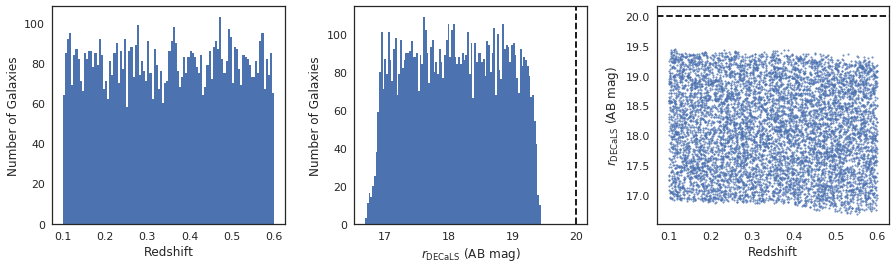

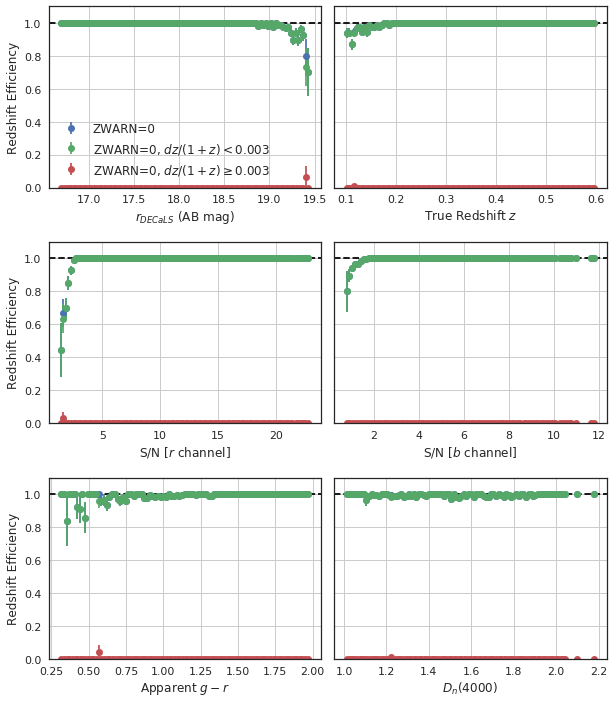

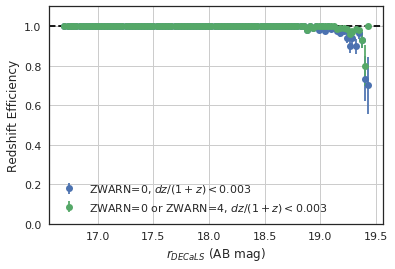

In [8]:
# sim 1
ind = 0
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)

Sim: sim02 with nspec: 4000 and nsim: 2
ObsConds ExpTime: 480, MoonFrac: 0.8, MoonAlt: 30, MoonSep: 120


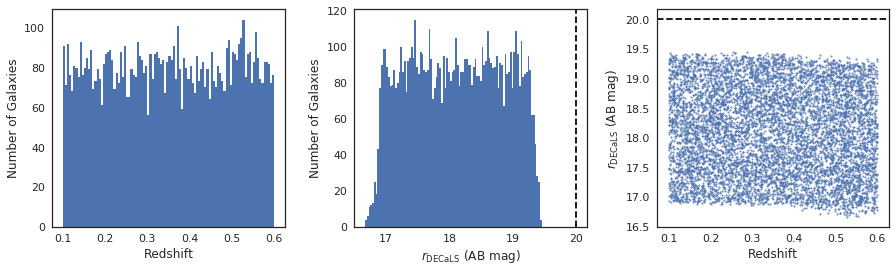

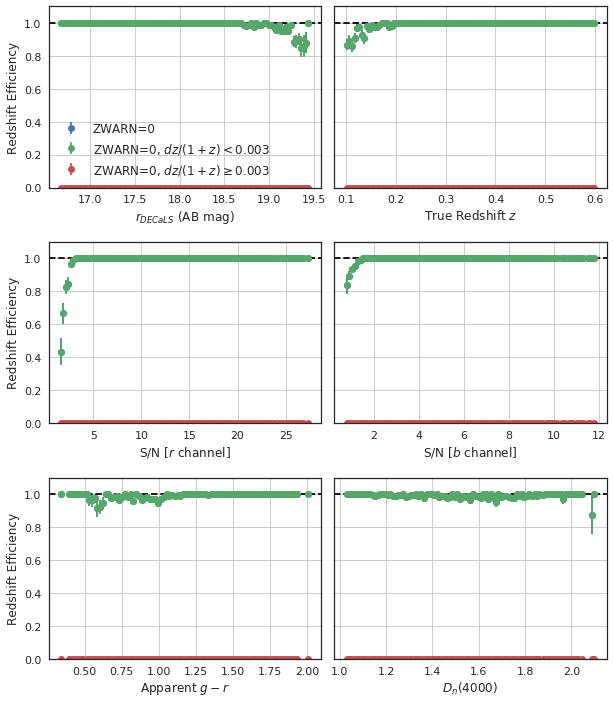

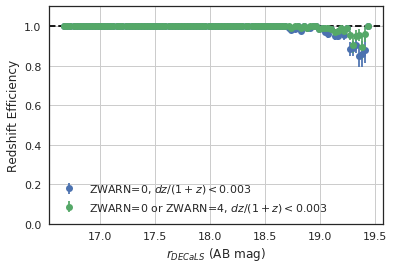

In [9]:
# sim 2
ind += 1
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)   

Sim: sim03 with nspec: 1000 and nsim: 10
ObsConds ExpTime: 300-720, MoonFrac: 0.8, MoonAlt: 30, MoonSep: 120


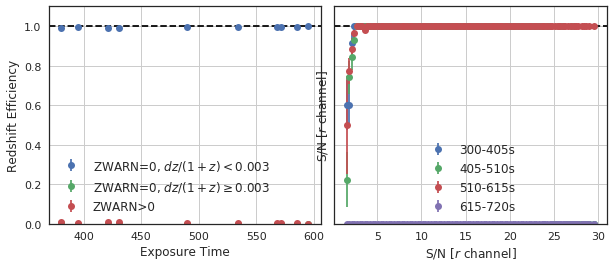

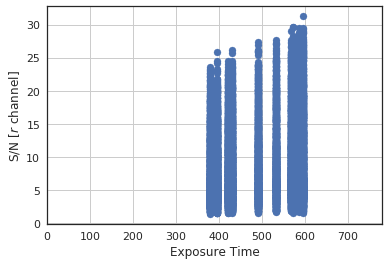

In [17]:
# sim 3
ind += 1
from desistudy_qa import qa_exptime
ind = 2
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    #qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    #qa_efficiency(result)
    #qa_zwarn4(result)
    qa_exptime(result,"zeff_vs_exptime.png")

Sim: sim04 with nspec: 1000 and nsim: 10
ObsConds ExpTime: 600, MoonFrac: 0.6-0.98, MoonAlt: 30, MoonSep: 120


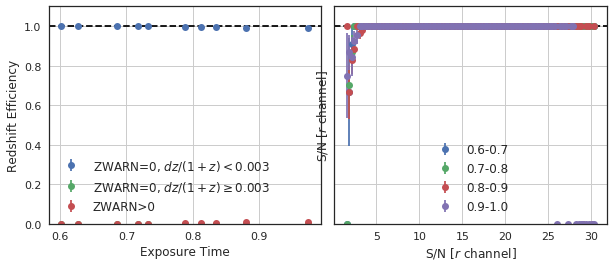

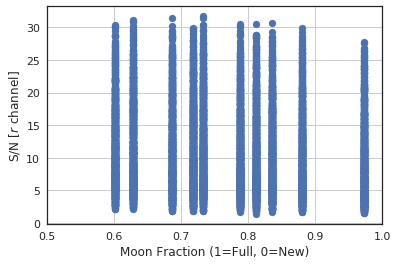

In [18]:
# sim 4
ind += 1
from desistudy_qa import qa_moonfrac
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    #qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    #qa_efficiency(result)
    #qa_zwarn4(result)
    qa_moonfrac(result,"zeff_vs_moonfrac.png")

In [13]:
np.histogram?

In [14]:
# sim 5
ind += 1
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)